## Fairness Analysis of NamSor's Gender API Endpoint using Aequitas

Part I: Fairness of Gender API Endpoint by Gender and Ethnicity

In [1]:
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot
import pdfkit as pdf

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("data/compas_gender_predictions.csv")
df.head()

,Unnamed: 0,entity_id,first,last,sex,sex_pred,race,score,label_value
0,0,1,miguel,hernandez,Male,Male,Other,0.000714,1.0
1,1,3,kevon,dixon,Male,Male,African-American,0.043280,1.0
2,2,4,ed,philo,Male,Male,African-American,0.031187,1.0
3,3,5,marcu,brown,Male,Male,African-American,0.377335,1.0
4,4,6,bouthy,pierrelouis,Male,Male,Other,0.490869,1.0


In [3]:
# Non String columns will lead to problems later so we have to find out if there are any
non_attr_cols = ['id', 'model_id', 'entity_id', 'score', 'label_value', 'rank_abs', 'rank_pct']
attr_cols = df.columns[~df.columns.isin(non_attr_cols)]  # index of the columns that are
df.columns[(df.dtypes != object) & (df.dtypes != str) & (df.columns.isin(attr_cols))]

Index(['Unnamed: 0'], dtype='object')

In [4]:
# And delete them.
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,entity_id,first,last,sex,sex_pred,race,score,label_value
0,1,miguel,hernandez,Male,Male,Other,0.000714,1.0
1,3,kevon,dixon,Male,Male,African-American,0.043280,1.0
2,4,ed,philo,Male,Male,African-American,0.031187,1.0
3,5,marcu,brown,Male,Male,African-American,0.377335,1.0
4,6,bouthy,pierrelouis,Male,Male,Other,0.490869,1.0


In [5]:
# we only want to look at gender here, since that is what we calculated label_value for
df = df.drop(['sex_pred', 'first', 'last'], axis=1) # if we don't drop the tables, Aequitas thinks these are attributes by which groups should be separated

In [6]:
# now we remove groups that are too small
df = df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])]

In [7]:
df.shape

(6787, 5)

In [8]:
df["combined_attribute"] = df["sex"] + " " + df["race"]

In [9]:
df.head()

,entity_id,sex,race,score,label_value,combined_attribute
1,3,Male,African-American,0.043280,1.0,Male African-American
2,4,Male,African-American,0.031187,1.0,Male African-American
3,5,Male,African-American,0.377335,1.0,Male African-American
6,8,Male,Caucasian,0.000248,1.0,Male Caucasian
8,10,Female,Caucasian,0.001108,1.0,Female Caucasian


## Group Metrics

In [10]:
t = 0.2
g = Group()
xtab, _ = g.get_crosstabs(df, attr_cols=["sex", "race"], score_thresholds= {'score': [t]})
absolute_metrics = g.list_absolute_metrics(xtab)

model_id, score_thresholds 0 {'score': [0.2]}


In [11]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,0.2_ore,6167,sex,Female,1189,133,60,94,39,1129,1223,99,1322,6787
1,0,0.2_ore,6167,sex,Male,4978,487,173,350,137,4805,5155,310,5465,6787
2,0,0.2_ore,6167,race,African-American,3194,502,153,363,139,3041,3404,292,3696,6787
3,0,0.2_ore,6167,race,Caucasian,2364,90,74,64,26,2290,2354,100,2454,6787
4,0,0.2_ore,6167,race,Hispanic,609,28,6,17,11,603,620,17,637,6787


In [12]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,sex,Female,0.92,0.39,0.71,0.05,0.61,0.08,0.29,0.95,0.19,0.90,0.93
1,sex,Male,0.93,0.44,0.72,0.03,0.56,0.07,0.28,0.97,0.81,0.91,0.94
2,race,African-American,0.89,0.48,0.72,0.05,0.52,0.11,0.28,0.95,0.52,0.86,0.92
3,race,Caucasian,0.97,0.26,0.71,0.03,0.74,0.03,0.29,0.97,0.38,0.96,0.96
4,race,Hispanic,0.97,0.65,0.61,0.01,0.35,0.03,0.39,0.99,0.10,0.96,0.97


## Disparities of Group Metrics

In [13]:
#aq_palette = sns.diverging_palette(240, 10, n=9) #sns.diverging_palette(225, 35, n=2)
b = Bias()

In [14]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'sex':'Male', 'race':'Caucasian'}, 
                                        input_group_metrics=["ppr", "tpr", "fpr", "precision", "tnr", "npv", "pprev", "for", "fdr", "fnr"],
                                        alpha=0.05, check_significance=False, 
                                        mask_significance=False)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,tpr_disparity,fpr_disparity,precision_disparity,tnr_disparity,npv_disparity,pprev_disparity,for_disparity,fdr_disparity,fnr_disparity,ppr_ref_group_value,tpr_ref_group_value,fpr_ref_group_value,precision_ref_group_value,tnr_ref_group_value,npv_ref_group_value,pprev_ref_group_value,for_ref_group_value,fdr_ref_group_value,fnr_ref_group_value
0,0,0.2_ore,6167,sex,Female,0.92314,0.393939,0.706767,0.0504626,0.606061,0.0768602,0.293233,0.949537,1189,133,0.1928,0.899395,60,94,39,1129,1223,99,1322,6787,0.925113,0.238851,0.990382,1.086,0.983725,0.891396,1.04237,0.987383,0.983416,1.45204,1.13204,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
1,0,0.2_ore,6167,sex,Male,0.932105,0.441935,0.718686,0.0347529,0.558065,0.0678952,0.281314,0.965247,4978,487,0.8072,0.910887,173,350,137,4805,5155,310,5465,6787,0.943275,1,1,1,1,1,1,1,1,1,1,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
2,0,0.2_ore,6167,race,African-American,0.893361,0.476027,0.723108,0.0479023,0.523973,0.106639,0.276892,0.952098,3194,502,0.517918,0.864177,153,363,139,3041,3404,292,3696,6787,0.920996,1.3511,0.918328,0.708071,0.982864,1.83087,0.958474,0.897078,1.01687,1.53028,3.92232,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
3,0,0.2_ore,6167,race,Caucasian,0.972812,0.26,0.711111,0.0313029,0.74,0.0271878,0.288889,0.968697,2364,90,0.383331,0.963325,74,64,26,2290,2354,100,2454,6787,0.95925,1,1,1,1,1,1,1,1,1,1,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
4,0,0.2_ore,6167,race,Hispanic,0.972581,0.647059,0.607143,0.00985222,0.352941,0.0274194,0.392857,0.990148,609,28,0.0987514,0.956044,6,17,11,603,620,17,637,6787,0.973312,0.257614,0.999762,0.476948,1.02214,2.48869,1.35989,0.992442,0.853795,0.314738,1.00852,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian


## Fairness Metrics

In [15]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [16]:
parity_detrminations = f.list_parities(fdf)

In [17]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + b.list_disparities(fdf) + parity_detrminations].style

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev,ppr_disparity,tpr_disparity,fpr_disparity,precision_disparity,tnr_disparity,npv_disparity,pprev_disparity,for_disparity,fdr_disparity,fnr_disparity,TypeI Parity,Statistical Parity,FDR Parity,NPV Parity,Supervised Fairness,TypeII Parity,Precision Parity,Equalized Odds,TPR Parity,TNR Parity,Unsupervised Fairness,Impact Parity,FOR Parity,FPR Parity,FNR Parity
0,sex,Female,0.92314,0.393939,0.706767,0.0504626,0.606061,0.0768602,0.293233,0.949537,0.1928,0.899395,0.925113,0.238851,0.990382,1.086,0.983725,0.891396,1.04237,0.987383,0.983416,1.45204,1.13204,False,False,False,True,False,True,True,True,True,True,False,True,True,True,True
1,sex,Male,0.932105,0.441935,0.718686,0.0347529,0.558065,0.0678952,0.281314,0.965247,0.8072,0.910887,0.943275,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,race,African-American,0.893361,0.476027,0.723108,0.0479023,0.523973,0.106639,0.276892,0.952098,0.517918,0.864177,0.920996,1.3511,0.918328,0.708071,0.982864,1.83087,0.958474,0.897078,1.01687,1.53028,3.92232,False,False,False,True,False,False,True,False,True,False,False,True,True,False,False
3,race,Caucasian,0.972812,0.26,0.711111,0.0313029,0.74,0.0271878,0.288889,0.968697,0.383331,0.963325,0.95925,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,race,Hispanic,0.972581,0.647059,0.607143,0.00985222,0.352941,0.0274194,0.392857,0.990148,0.0987514,0.956044,0.973312,0.257614,0.999762,0.476948,1.02214,2.48869,1.35989,0.992442,0.853795,0.314738,1.00852,False,False,False,False,False,True,True,False,True,False,False,True,True,False,True


In [18]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,0.2_ore,race,False,True,False,False,True,False,True,False,False,True,False,False,False,False,False
1,0,0.2_ore,sex,False,True,False,True,True,True,True,True,True,True,False,True,True,False,False


In [19]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

### Visualize fairness

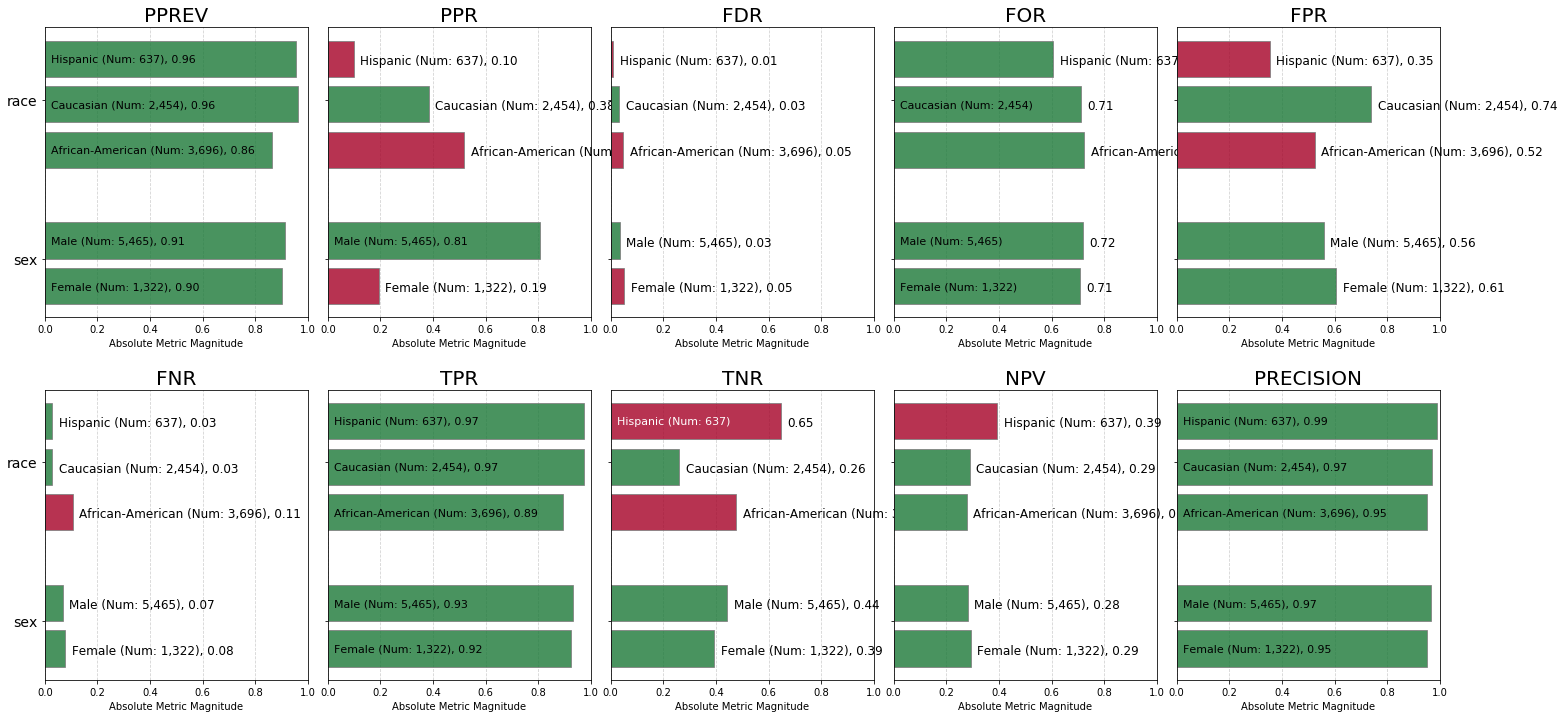

<Figure size 432x288 with 0 Axes>

In [20]:
aqp = Plot()
fg = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")

## Impact of Treshold chosen

In [21]:
from numpy import arange

res = pd.DataFrame({'model_id' : []})
all_tables = []
complete_tables = []

g = Group()

tresholds = arange(0.1, 0.5, 0.1)
for t in tresholds:
    xtab, _ = g.get_crosstabs(df, 
                              attr_cols=["combined_attribute"], 
                              score_thresholds= {'score': [t]})
    absolute_metrics = g.list_absolute_metrics(xtab)
    b = Bias()
    bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                            ref_groups_dict={'combined_attribute':'Male Caucasian'}, 
                                            input_group_metrics=["ppr", "tpr", "fpr", "precision", "tnr", "npv", "pprev", "for", "fdr", "fnr"],
                                            check_significance=False, 
                                            mask_significance=False)
    bdf['model_id'] = t
    res = res.append(bdf, sort=False)
    complete_tables.append(bdf)
    all_tables.append(bdf[["attribute_value", "ppr_disparity", "tpr_disparity", "fpr_disparity", "precision_disparity", "tnr_disparity", "npv_disparity", "pprev_disparity", "for_disparity", "fdr_disparity", "fnr_disparity"]])

model_id, score_thresholds 0 {'score': [0.1]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'score': [0.2]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'score': [0.30000000000000004]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'score': [0.4]}
get_disparity_predefined_group()


In [22]:
overview = res[["model_id", "attribute_value", "ppr_disparity", "tpr_disparity", "fpr_disparity", "precision_disparity", "tnr_disparity", "npv_disparity", "pprev_disparity", "for_disparity", "fdr_disparity", "fnr_disparity"]].groupby(["model_id", "attribute_value"]).mean()

In [23]:
overview

ppr_disparity  tpr_disparity  fpr_disparity  \
model_id attribute_value                                                        
0.1      Female African-American       0.289608       0.869886       0.641667   
         Female Caucasian              0.294151       0.995487       0.776471   
         Female Hispanic               0.053947       0.988362       0.000000   
         Male African-American         1.385009       0.880304       0.662573   
         Male Caucasian                1.000000       1.000000       1.000000   
         Male Hispanic                 0.276547       0.989487       0.366667   
0.2      Female African-American       0.300000       0.894088       0.721875   
         Female Caucasian              0.298901       1.003721       0.931765   
         Female Hispanic               0.054396       0.988468       1.320000   
         Male African-American         1.454945       0.924325       0.683158   
         Male Caucasian                1.000000       1.000000       1.000000   
         Male Hispanic                 0.280220       1.002994       0.412500   
0.3      Female African-American       0.305298       0.908203       0.748162   
         Female Caucasian              0.297652       1.000001       0.913495   
         Female Hispanic               0.054069       0.982915       1.294118   
         Male African-American         1.466958       0.930394       0.709494   
         Male Caucasian                1.000000       1.000000       1.000000   
         Male Hispanic                 0.278536       0.997359       0.404412   
0.4      Female African-American       0.325230       0.961654       0.840278   
         Female Caucasian              0.298217       1.001948       0.898693   
         Female Hispanic               0.054565       0.993486       1.222222   
         Male African-American         1.535386       0.964775       0.863060   
         Male Caucasian                1.000000       1.000000       1.000000   
         Male Hispanic                 0.282550       1.005530       0.687500   

                                  precision_disparity  tnr_disparity  \
model_id attribute_value                                               
0.1      Female African-American             0.969882       1.767857   
         Female Caucasian                    0.990563       1.478992   
         Female Hispanic                     1.026224       3.142857   
         Male African-American               0.982886       1.723058   
         Male Caucasian                      1.000000       1.000000   
         Male Hispanic                       1.017795       2.357143   
0.2      Female African-American             0.962335       1.869141   
         Female Caucasian                    0.982885       1.213235   
         Female Hispanic                     1.017862       0.000000   
         Male African-American               0.982428       1.990132   
         Male Caucasian                      1.000000       1.000000   
         Male Hispanic                       1.018168       2.835938   
0.3      Female African-American             0.960566       1.856250   
         Female Caucasian                    0.983353       1.294118   
         Female Hispanic                     1.018261       0.000000   
         Male African-American               0.980781       1.987719   
         Male Caucasian                      1.000000       1.000000   
         Male Hispanic                       1.018567       3.025000   
0.4      Female African-American             0.954764       1.718750   
         Female Caucasian                    0.983399       1.455882   
         Female Hispanic                     1.019852       0.000000   
         Male African-American               0.971697       1.616228   
         Male Caucasian                      1.000000       1.000000   
         Male Hispanic                       1.012325       2.406250   

                                  npv_disparity  pprev

In [24]:
overview.to_html('data/disparities_by_treshold_gender.html')

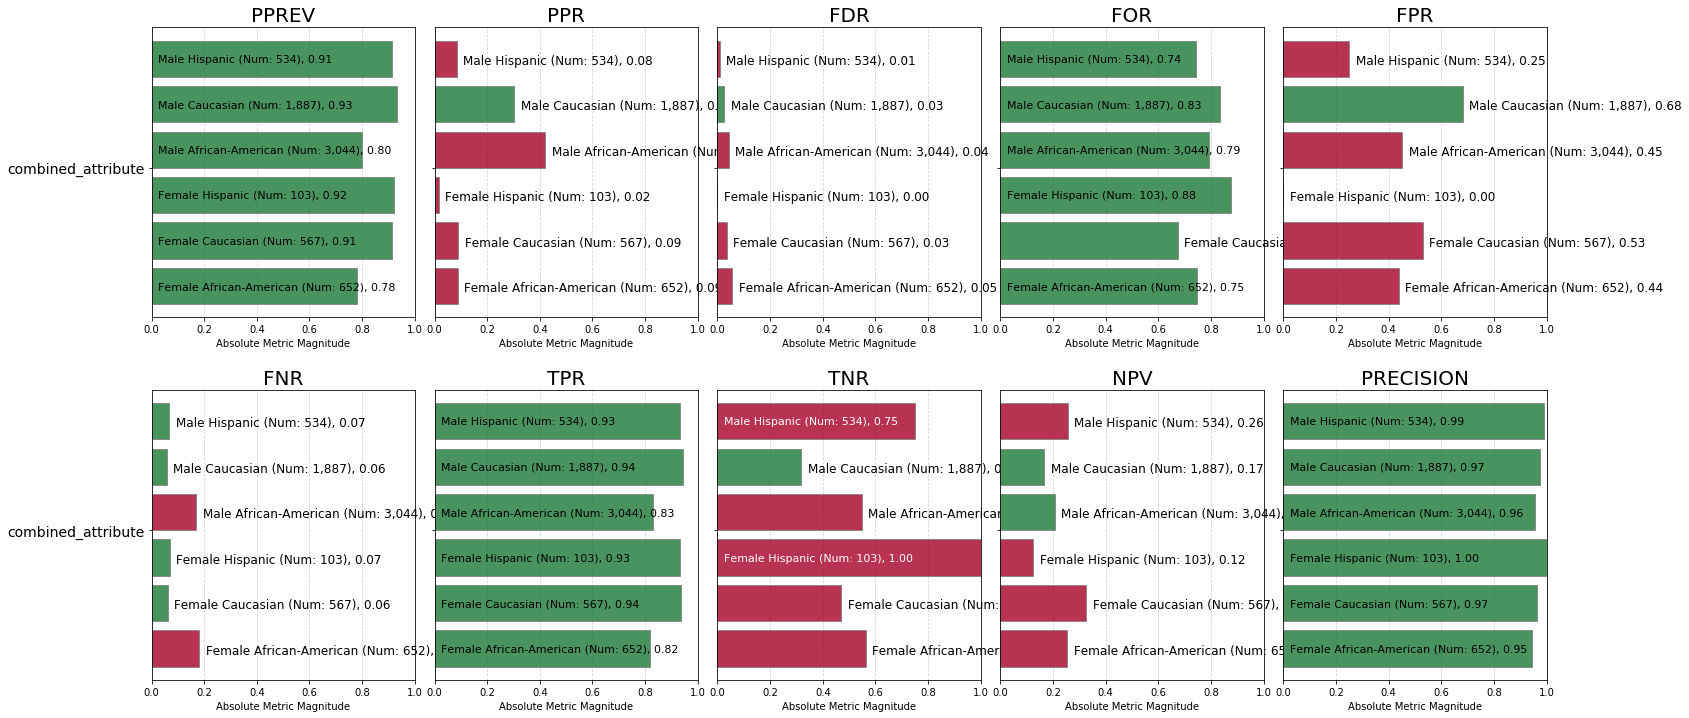

<Figure size 432x288 with 0 Axes>

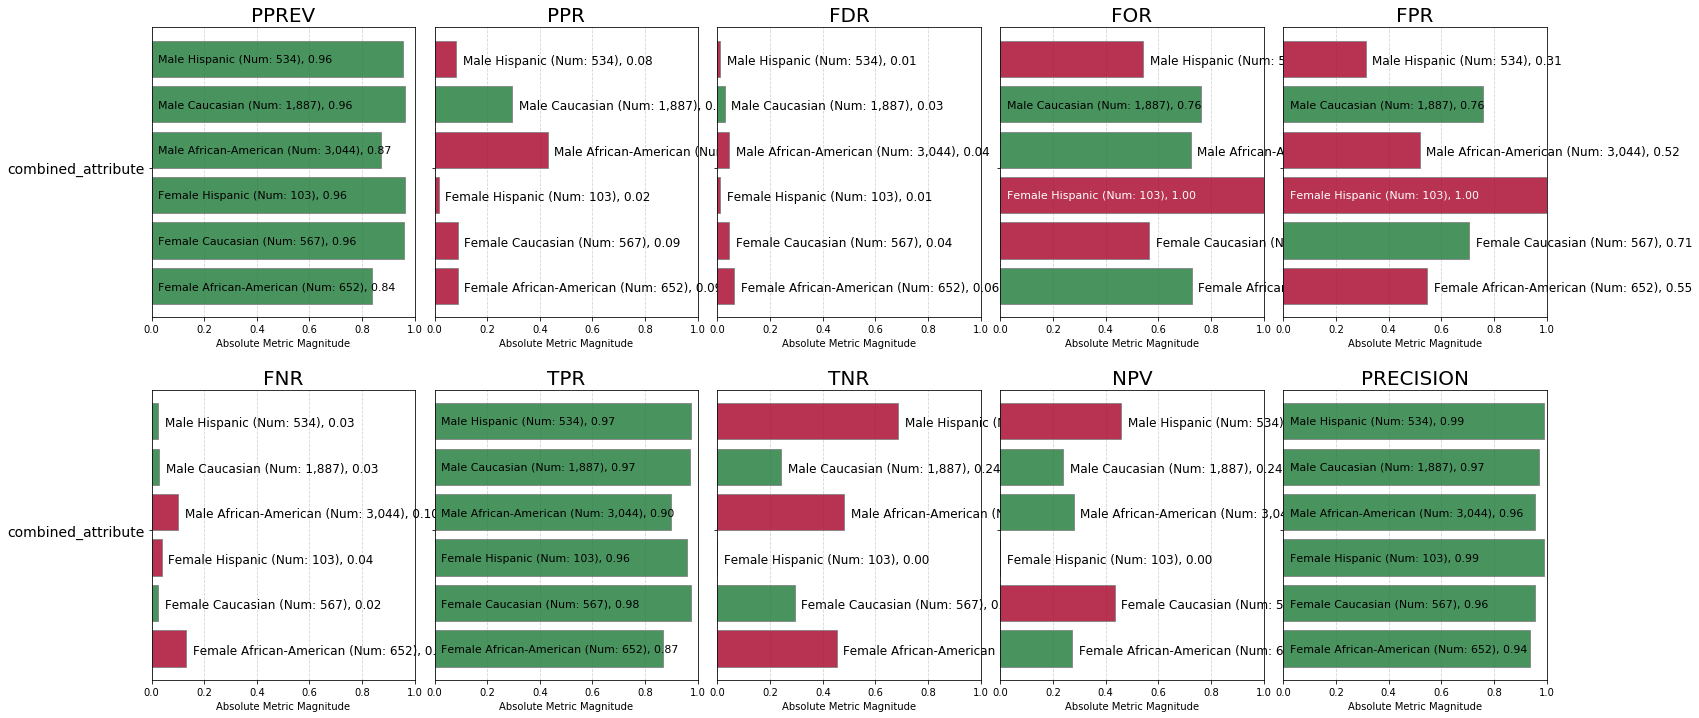

<Figure size 432x288 with 0 Axes>

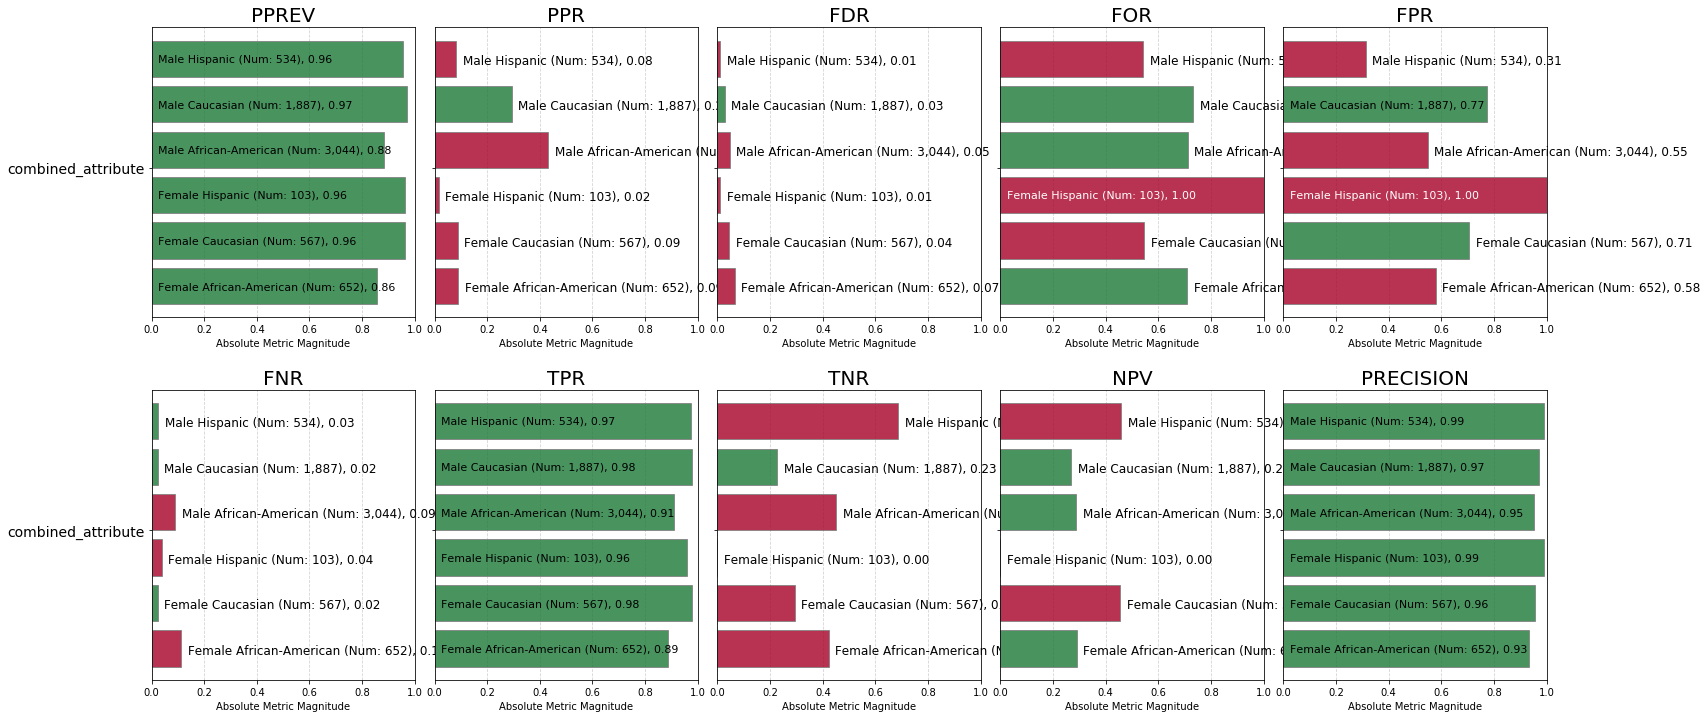

<Figure size 432x288 with 0 Axes>

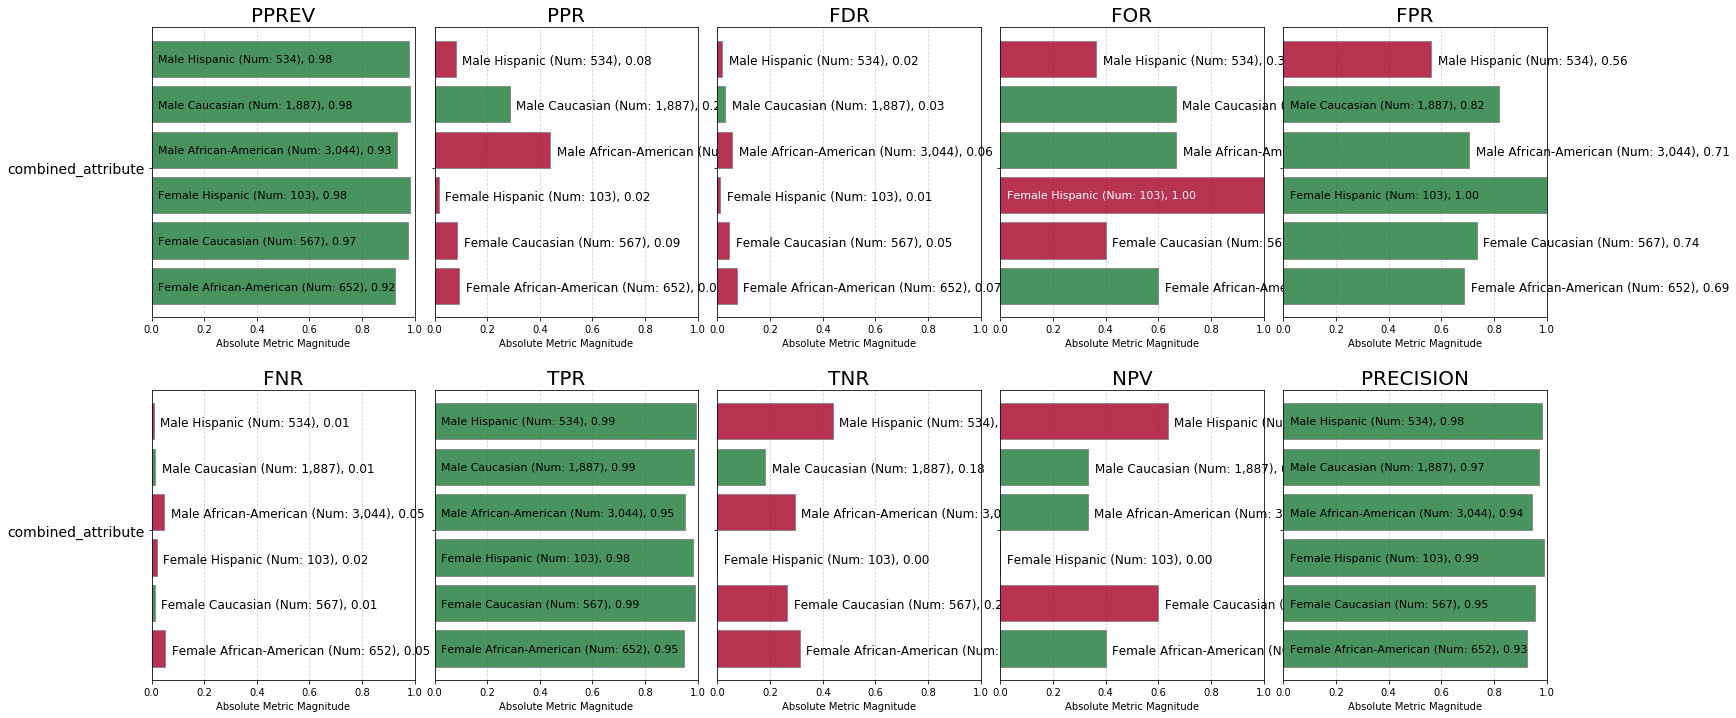

<Figure size 432x288 with 0 Axes>

In [26]:
i = 0.1
for table in complete_tables:
    fdf = f.get_group_value_fairness(table)
    plot = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")
    plot.savefig('graphics/gender_endpoint_disparities_{}.pdf'.format(i), format='pdf')
    i = i + 0.1

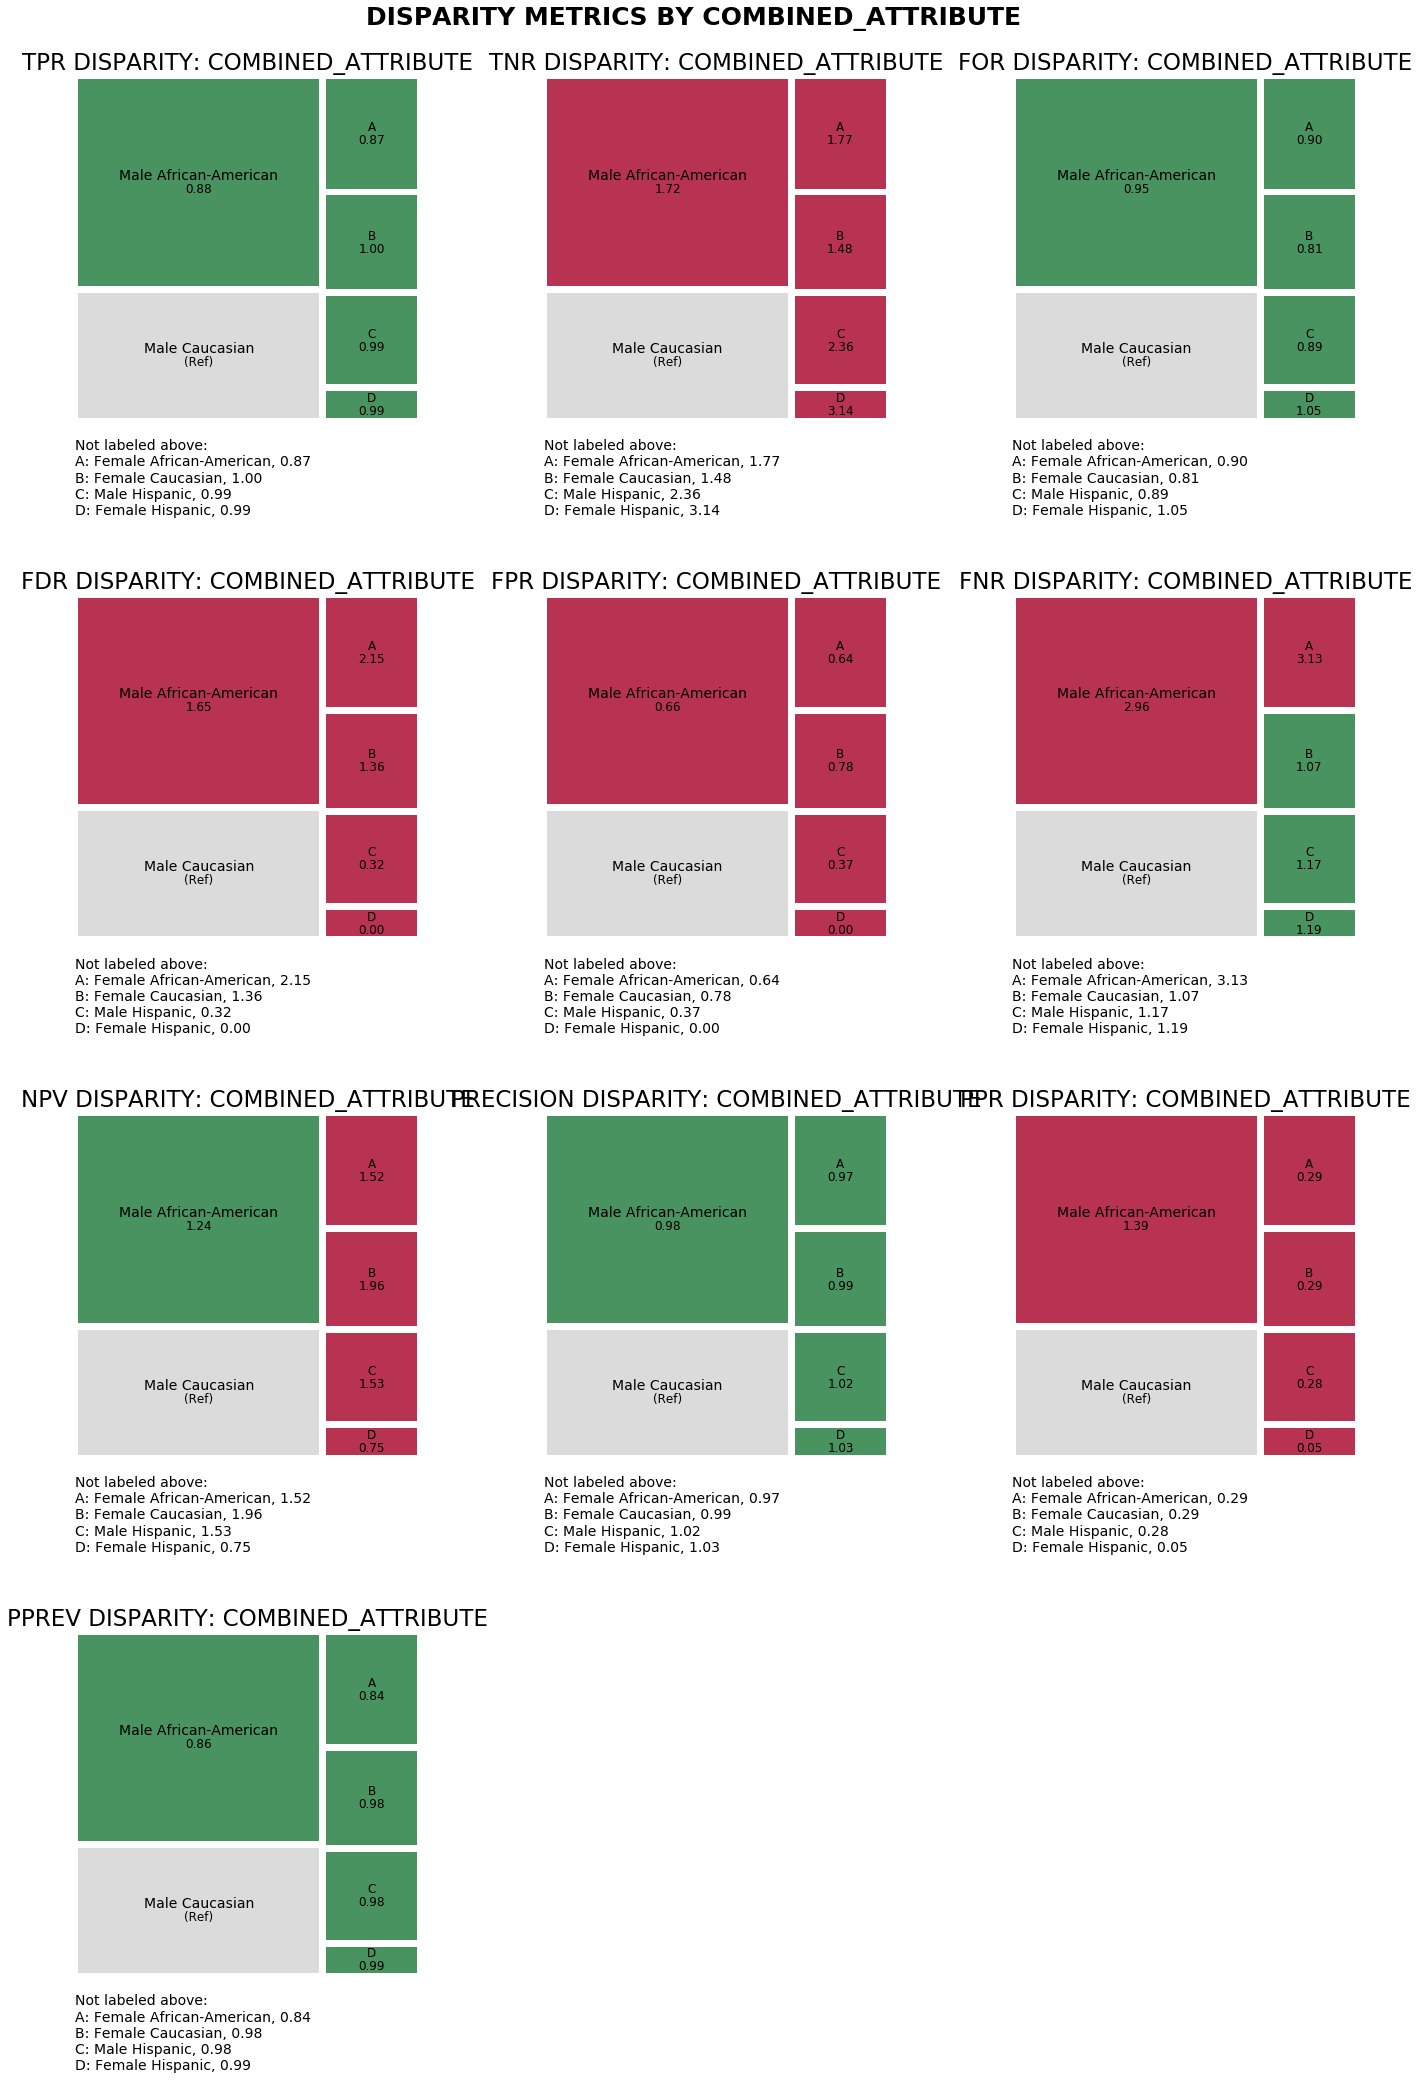

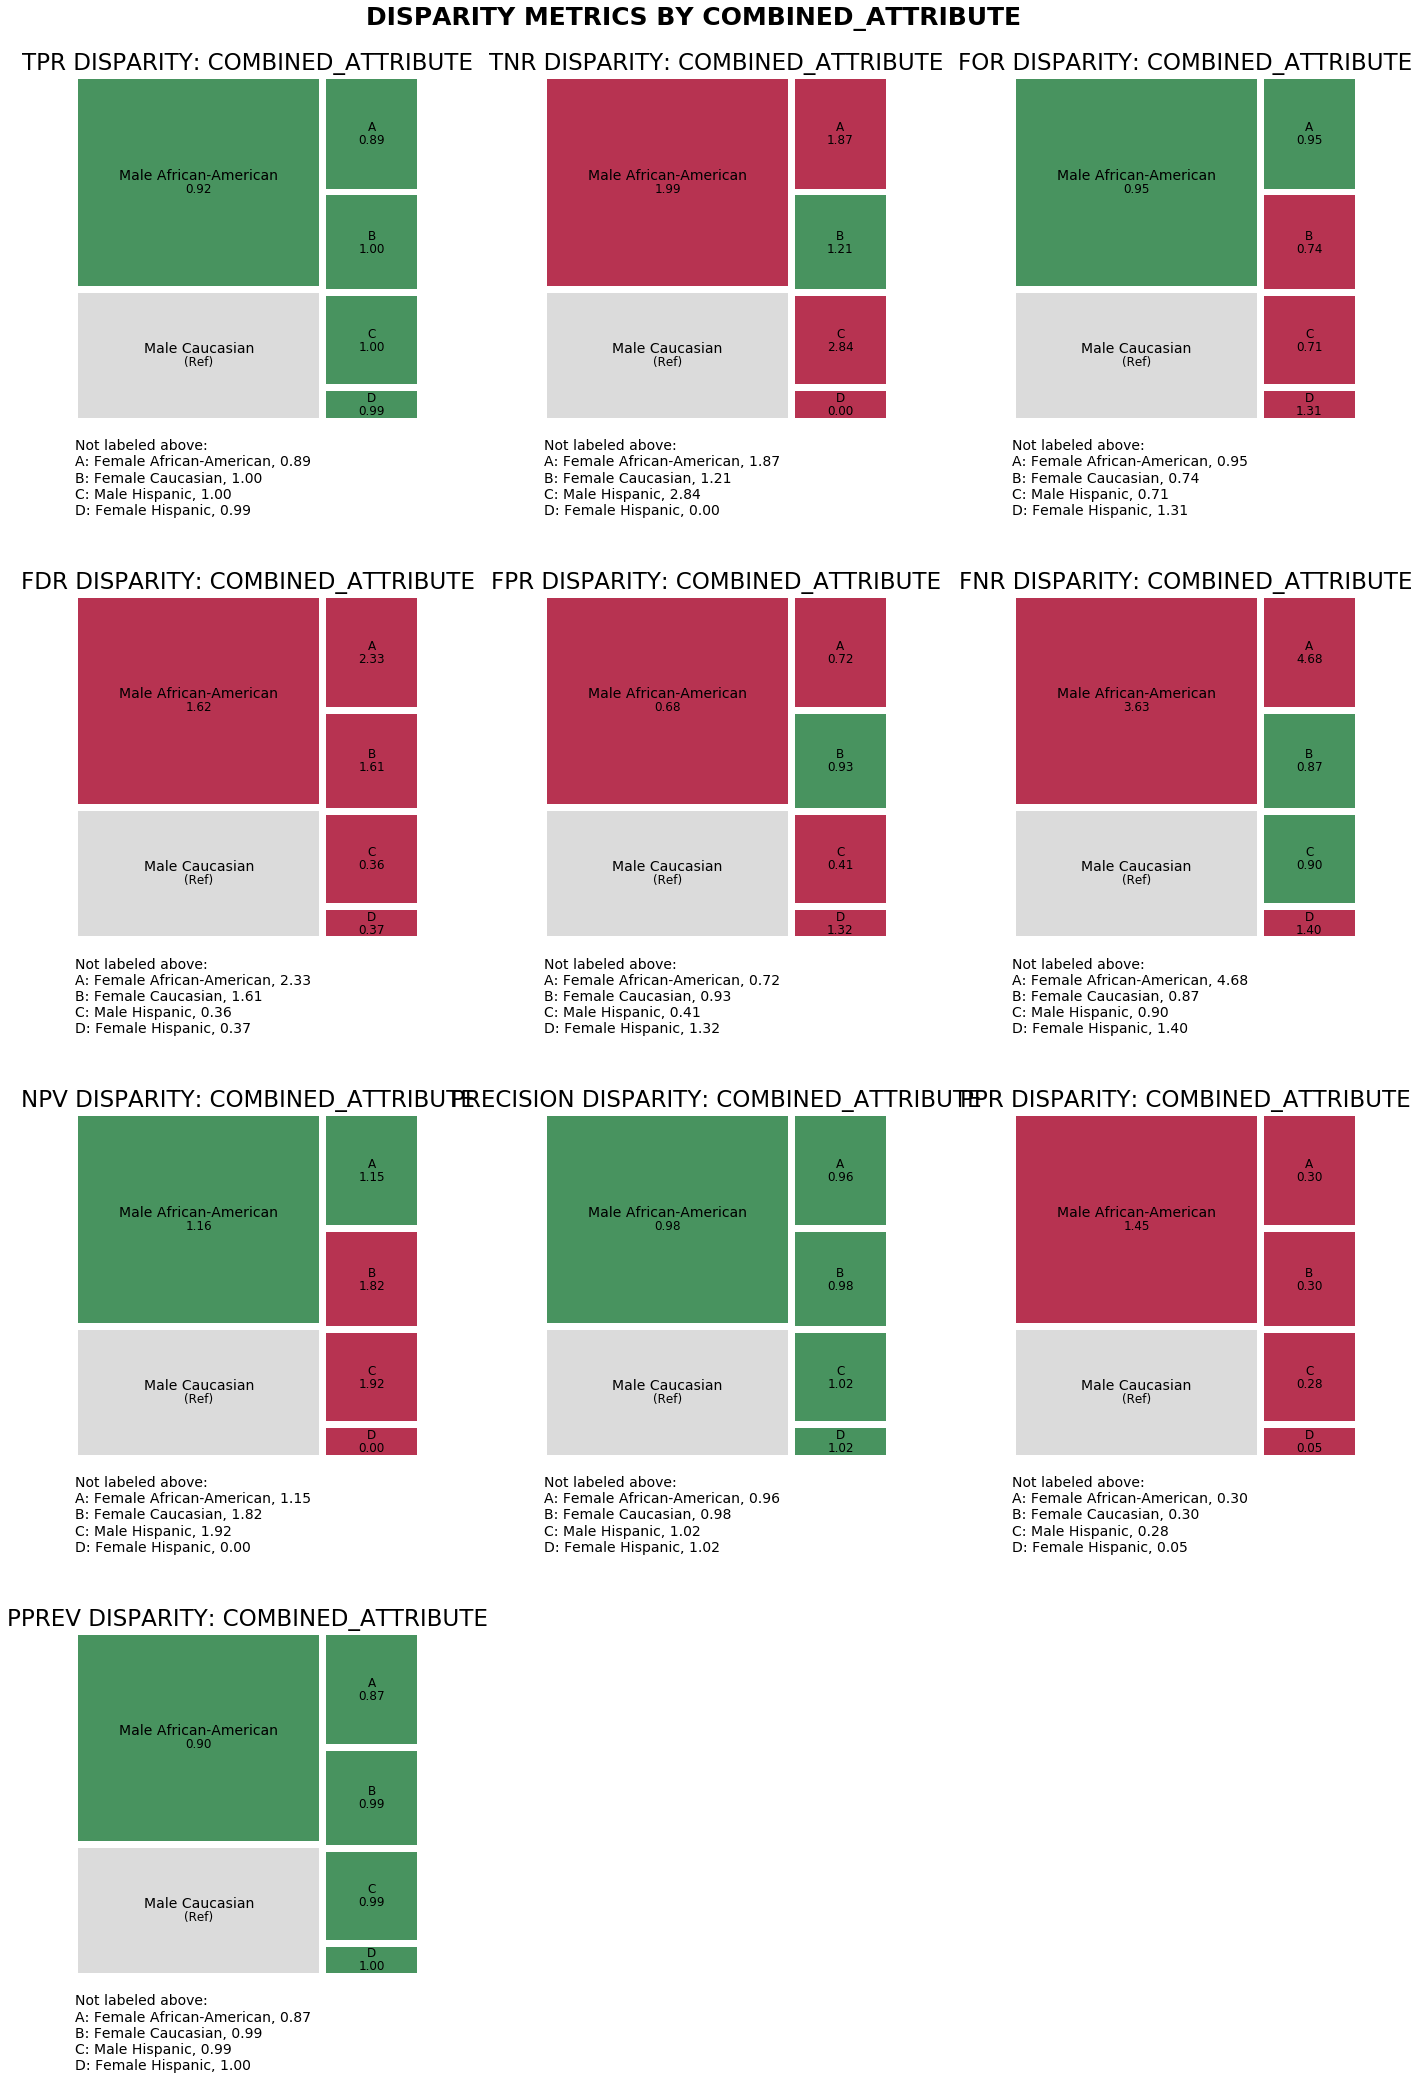

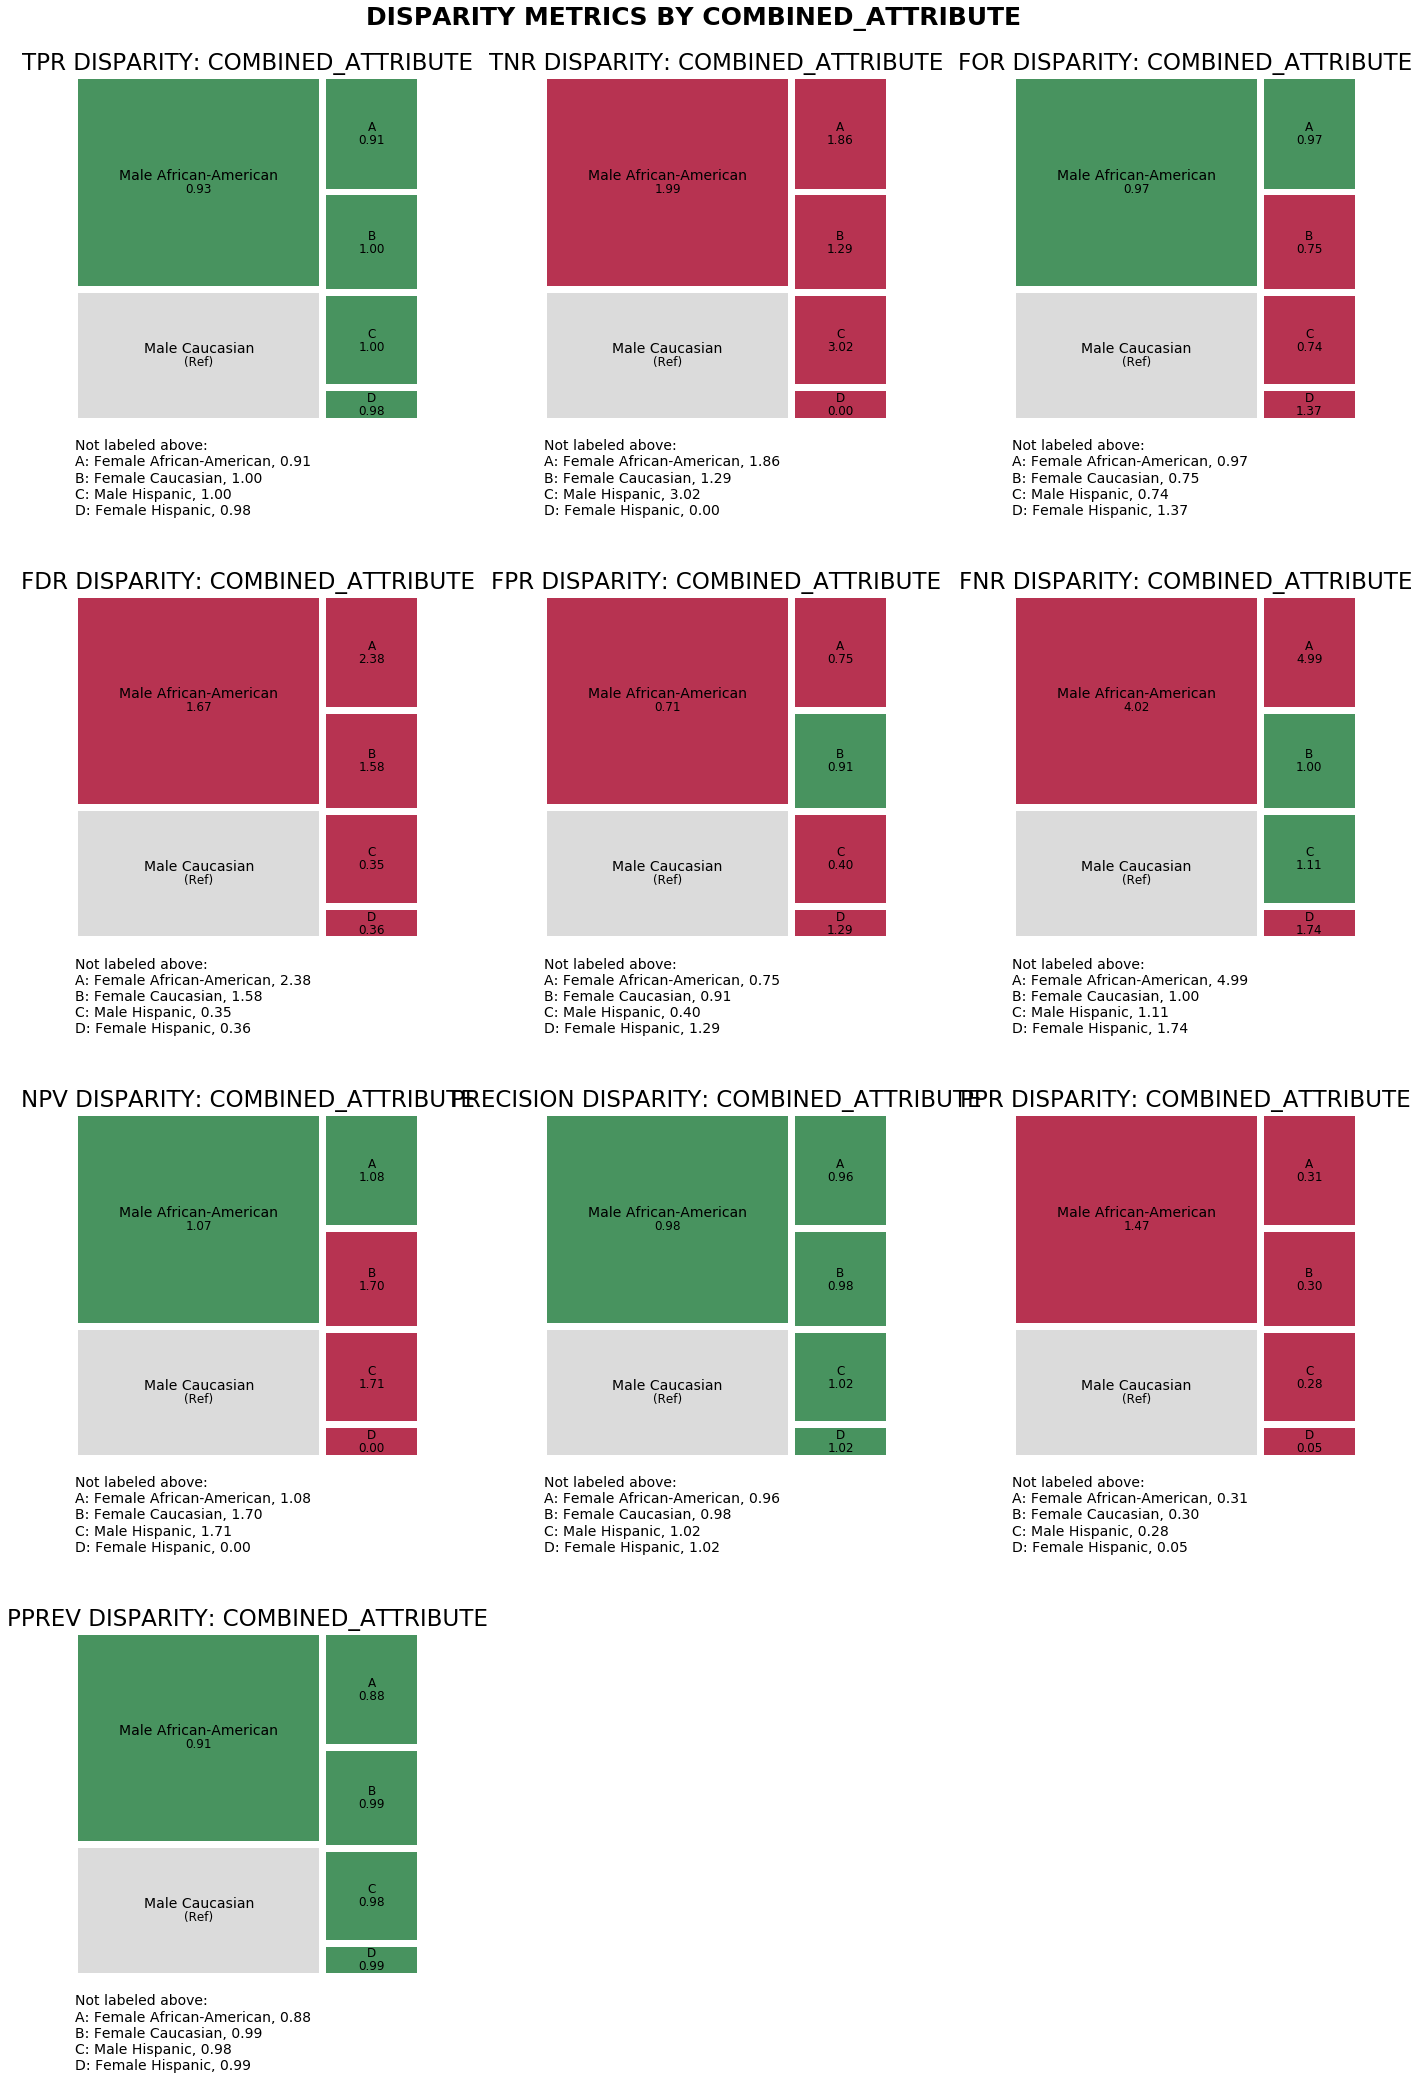

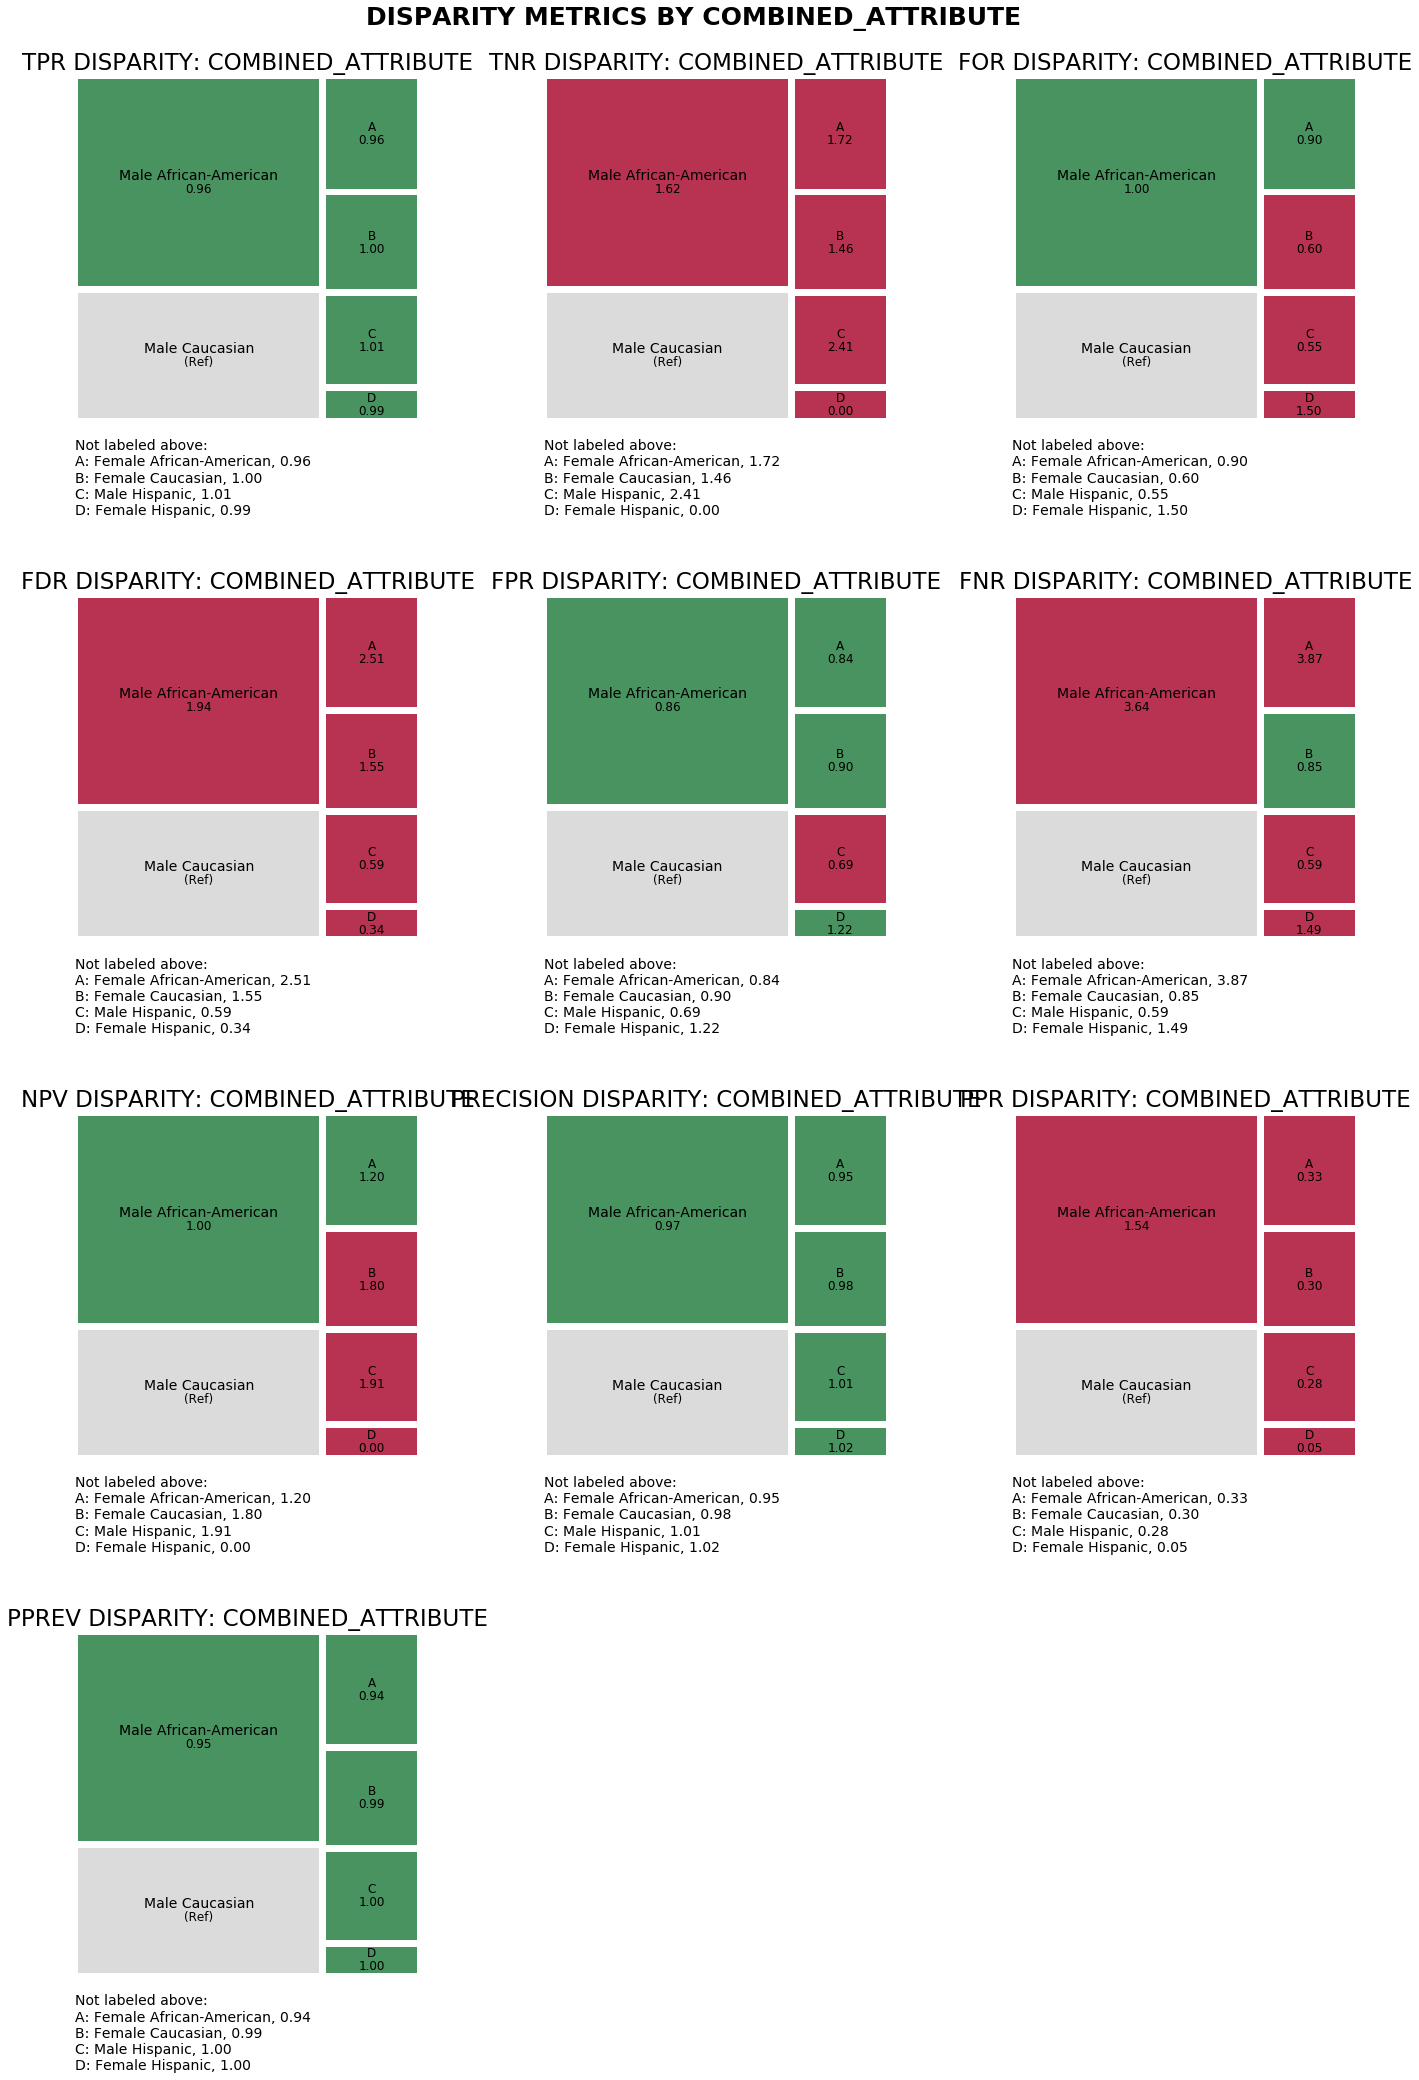

In [27]:
i = 0.1
for table in complete_tables:
    fdf = f.get_group_value_fairness(table)
    plot = aqp.plot_fairness_disparity_all(fdf, attributes=['combined_attribute'], metrics='all', 
                                       significance_alpha=0.05)
    plot.savefig('graphics/gender_endpoint_disparities_{}_2.pdf'.format(i), format='pdf')
    i = i + 0.1